In [10]:
from src.data.datasets import SiteDataset
import jax.numpy as jnp
site_data = SiteDataset("5a0546857ecc773753327266")

floor = site_data.floors[0]
trace = floor.traces[0]
matrices = trace.matrices
position = matrices["position"]
wifi = matrices["wifi"]
from numpyro import handlers
import numpyro.distributions as dist
from numpyro import sample, plate
import numpyro
from jax import lax

In [3]:
height, width = floor.info["map_info"]["height"], floor.info["map_info"]["width"]
floor_uniform = dist.Independent(
    dist.Uniform(low=jnp.array([0, 0]), high=jnp.array([height, width])), 1
)


In [58]:
def f(carry, noise_t):
  x_pre,sigma = carry
  x_t = x_pre + sigma*noise_t
  x_pre = x_t
  return (x_pre, sigma), x_t

In [136]:
def initial_model(wifi, position=None, pos_is_observed=None, pos_is_not_observed=None):
    T = position.shape[0]
    K = wifi.shape[1]

    pos_observed = None if position is None else position[pos_is_observed]

    sigma_eps = 0.1
    sigma = 0.1

    mu_omega_0 = -45
    sigma_omega_0 = 5
    sigma_omega = 2

    with plate("wifis", K):
        omega_0 = sample("omega_0", dist.Normal(mu_omega_0, sigma_omega_0))
        wifi_locations = sample("wifi_location", floor_uniform)

    x = jnp.zeros((T, 2))

    x0 = sample("x_0", floor_uniform)

    noises = sample("noises", fn=dist.Normal(0, 1), sample_shape=(T - 1, 2))
    # Propagate the dynamics forward using jax.lax.scan
    carry = (x0, sigma)
    x_collection = [x0]
    carry, x = lax.scan(f, carry, noises, T - 1)
    x = jnp.concatenate((jnp.array(x_collection), x), axis=0)

    x_hat = sample(
        name="x_hat",
        fn=dist.Normal(loc=x[pos_is_observed], scale=sigma_eps),
        obs=pos_observed,
    )

    x_hat_mis = sample(
        name="x_hat_mis",
        fn=dist.Normal(loc=x[pos_is_not_observed], scale=sigma_eps),
        obs=pos_observed,
    )

    return x

with handlers.seed(rng_seed=0):
    print(initial_model(wifi, position))


[[38.135307 68.67628 ]
 [38.056553 68.642265]
 [37.946552 68.63873 ]
 [37.97909  68.583626]
 [37.949886 68.656395]
 [37.962654 68.659966]
 [38.11119  68.54168 ]
 [38.207478 68.634254]
 [38.072914 68.587715]
 [37.99999  68.60539 ]
 [37.873966 68.50273 ]
 [37.942818 68.5825  ]
 [37.862564 68.474945]
 [37.79819  68.48227 ]
 [37.93768  68.58752 ]
 [37.943264 68.62267 ]
 [38.04709  68.667076]
 [38.050323 68.5576  ]
 [38.179985 68.62399 ]
 [38.154797 68.652954]
 [38.101173 68.74847 ]
 [38.183308 68.85055 ]
 [38.341476 68.994606]
 [38.19653  68.96381 ]
 [38.08619  68.94941 ]
 [38.221943 69.04022 ]
 [38.22737  69.04956 ]
 [38.196438 69.07608 ]
 [38.232944 69.05867 ]
 [38.229874 69.00477 ]
 [38.26203  69.09179 ]
 [38.322178 69.04249 ]
 [38.27491  69.00272 ]
 [38.328686 68.95507 ]
 [38.274864 68.96926 ]
 [38.182465 68.916664]
 [38.173286 68.833496]
 [38.089085 68.752304]
 [38.06702  68.65848 ]
 [38.246414 68.5908  ]
 [38.098083 68.705574]
 [38.04978  68.63949 ]
 [38.195652 68.49259 ]
 [38.268425

In [119]:
import time
from jax import random, vmap
from numpyro.infer import MCMC, NUTS

t0 = time.time()

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

pos_is_observed = ~jnp.isnan(position[:, 0])
pos_is_not_observed = jnp.isnan(position[:, 0])

numpyro.set_host_device_count(4)

nuts_kernel = NUTS(model=initial_model)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000, num_chains=4)
mcmc.run(
    rng_key_,
    wifi=jnp.array(wifi),
    position=jnp.array(position),
    pos_is_not_observed=pos_is_not_observed,
    pos_is_observed=pos_is_observed,
)

t_fin = time.time()

print("Total time: {0:.3f}m".format((t_fin - t0) / 60))


/home/simon/Documents/indoor-location-navigation/.venv/lib/python3.8/site-packages/numpyro/infer/mcmc.py:257: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn('There are not enough devices to run parallel chains: expected {} but got {}.'
sample: 100%|██████████| 2000/2000 [00:16<00:00, 124.48it/s, 127 steps of size 4.10e-02. acc. prob=0.92]


Total time: 2.400m


In [138]:
mcmc.print_summary()


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
         noises[0,0]      2.62      0.97      2.62      1.01      4.16  10952.52      1.00
         noises[0,1]      0.49      0.99      0.49     -1.12      2.10   9995.69      1.00
         noises[1,0]      2.64      0.99      2.64      1.05      4.33  10469.46      1.00
         noises[1,1]      0.49      1.01      0.49     -1.16      2.07  14956.59      1.00
         noises[2,0]      2.62      0.94      2.62      1.08      4.14  11284.09      1.00
         noises[2,1]      0.49      1.00      0.50     -1.09      2.15  12115.54      1.00
         noises[3,0]      2.62      0.99      2.62      0.97      4.15  10095.02      1.00
         noises[3,1]      0.49      0.97      0.48     -1.06      2.15  10262.98      1.00
         noises[4,0]      2.63      1.01      2.64      0.95      4.30  10752.18      1.00
         noises[4,1]      0.49      1.00      0.49     -1.08      2.18  12325.06      1.0

In [126]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}

In [132]:
X = hmc_samples["x_0"] + jnp.cumsum(hmc_samples["noises"], axis = 1).transpose((1,0,2))*0.1

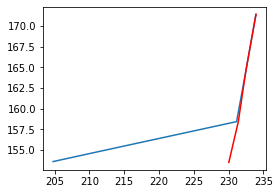

In [133]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,3))
plt.plot(*jnp.mean(X, axis=1).T)
plt.plot(*position[pos_is_observed].T, color = "red")
plt.show()